# [Tools란?](https://python.langchain.com/docs/concepts/tool_calling/)
- LLM이 실행할 수 있는 구체적인 기능을 정의한 것.
- 예: 웹 검색, DB 질의, API 호출, 계산기 등

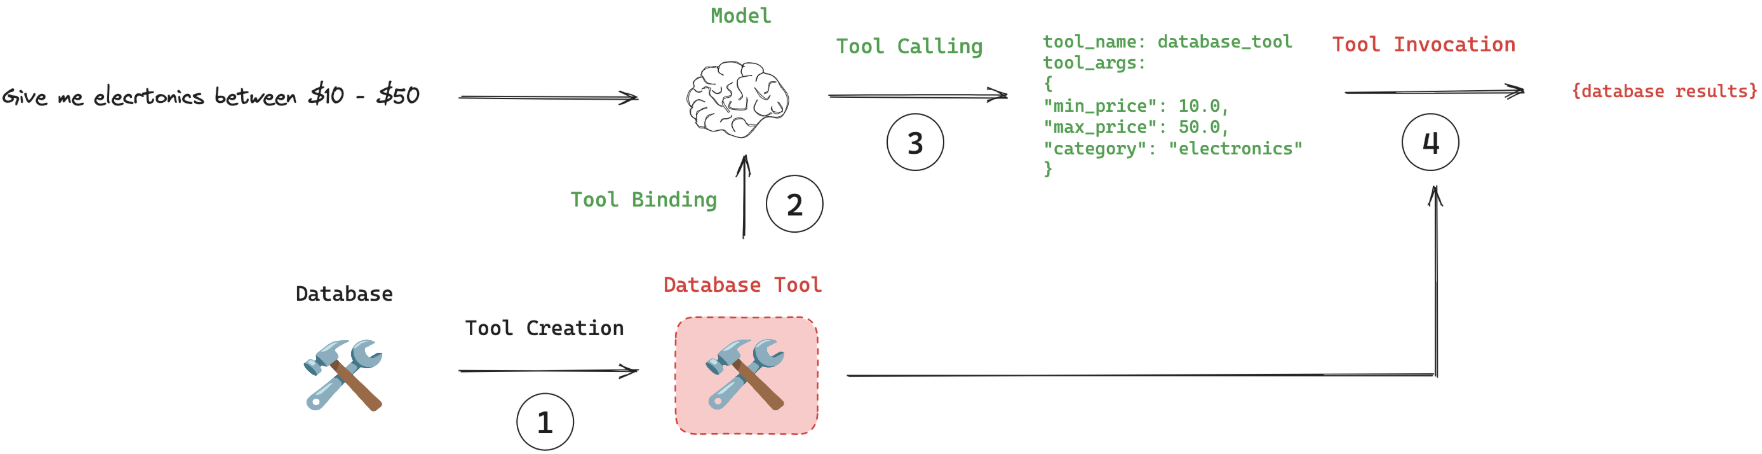

1. `도구 생성`: @tool 데코레이터를 사용하여 도구를 생성합니다 . 도구는 함수와 해당 스키마 간의 연결입니다.
2. `도구 바인딩`: 도구는 도구 호출을 지원하는 모델에 연결되어야 합니다. 이를 통해 모델이 도구와 도구에 필요한 관련 입력 스키마를 인식할 수 있습니다.
3. `도구 호출`: 적절한 경우 모델은 도구를 호출하고 해당 응답이 도구의 입력 스키마에 부합하는지 확인할 수 있습니다.
4. `도구 실행`: 도구는 모델이 제공한 인수를 사용하여 실행될 수 있습니다.

# Agents (에이전트)
- 여러 개의 Tools를 관리하고, 어떤 Tool을 어떤 순서로 사용할지 결정하는 역할을 담당합니다.

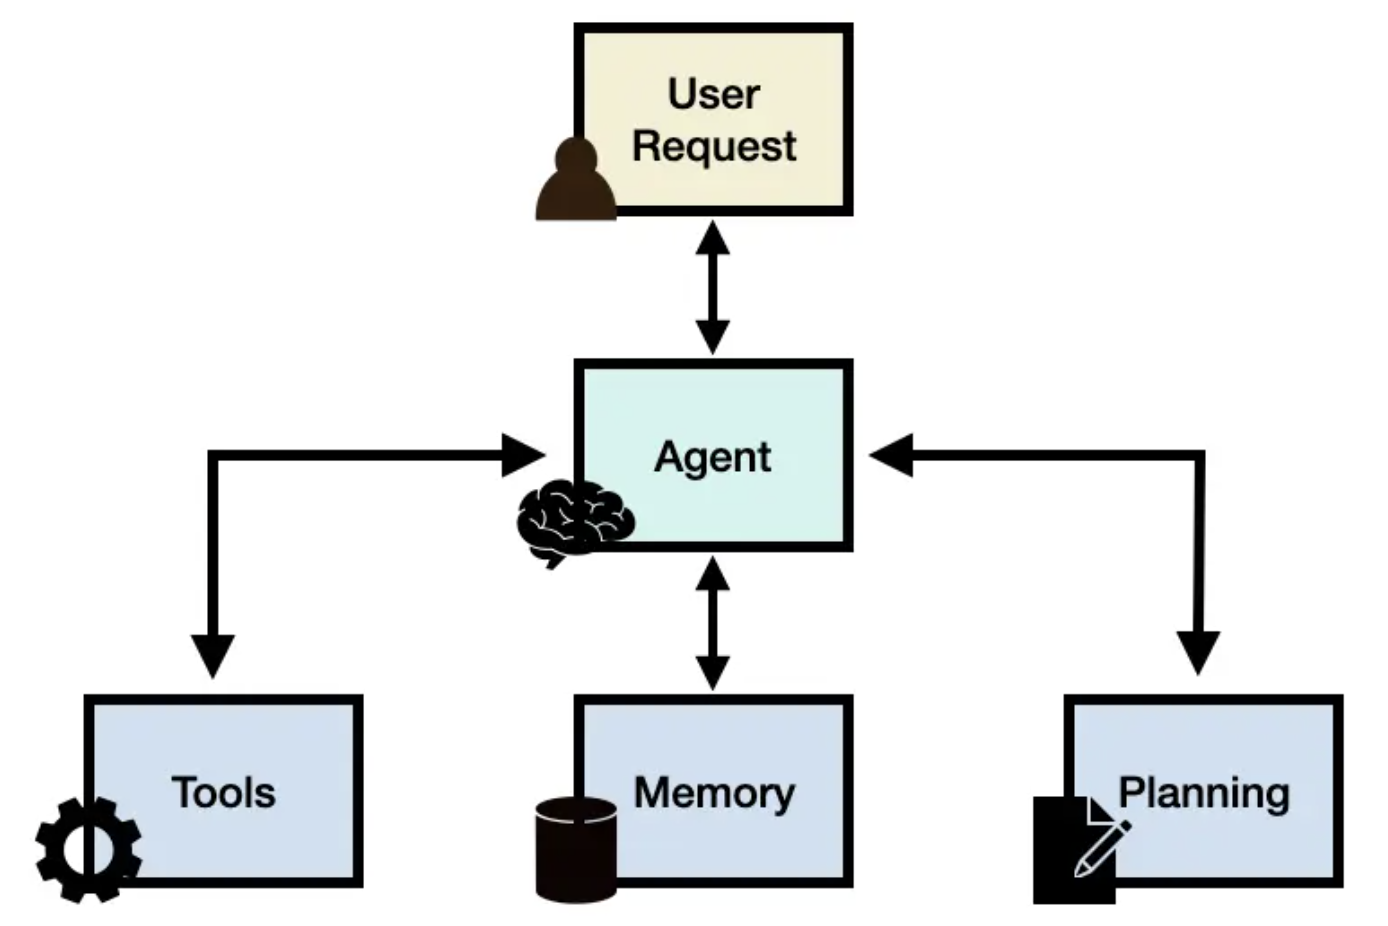

## Tools vs Agents
- Tools는 "LLM이 사용할 수 있는 도구"
- Agents는 "도구를 언제, 어떻게 사용할지 결정하는 지능"

# TavilySearchResults를 이용한 Tool 생성
- TavilySearchResults는 실시간 웹 검색을 수행할 수 있는 도구입니다. 최신 정보를 검색하고 요약할 수 있습니다.


### 핵심 포인트:
1. **실시간 검색**: 최신 정보를 실시간으로 검색
2. **다양한 소스**: 뉴스, 날씨, 주식 등 다양한 정보 소스 활용
3. **검색 최적화**: max_results, search_depth 등으로 검색 품질 조절
4. **LCEL 통합**: 다른 도구들과 함께 사용하여 강력한 정보 분석 시스템 구축


### 주의사항:
- Tavily API 키가 필요합니다 (https://tavily.com/)
- 검색 결과는 실시간으로 변경될 수 있습니다
- API 사용량 제한이 있을 수 있으니 확인하세요

## [Tavily 가입/로그인](https://www.tavily.com/)

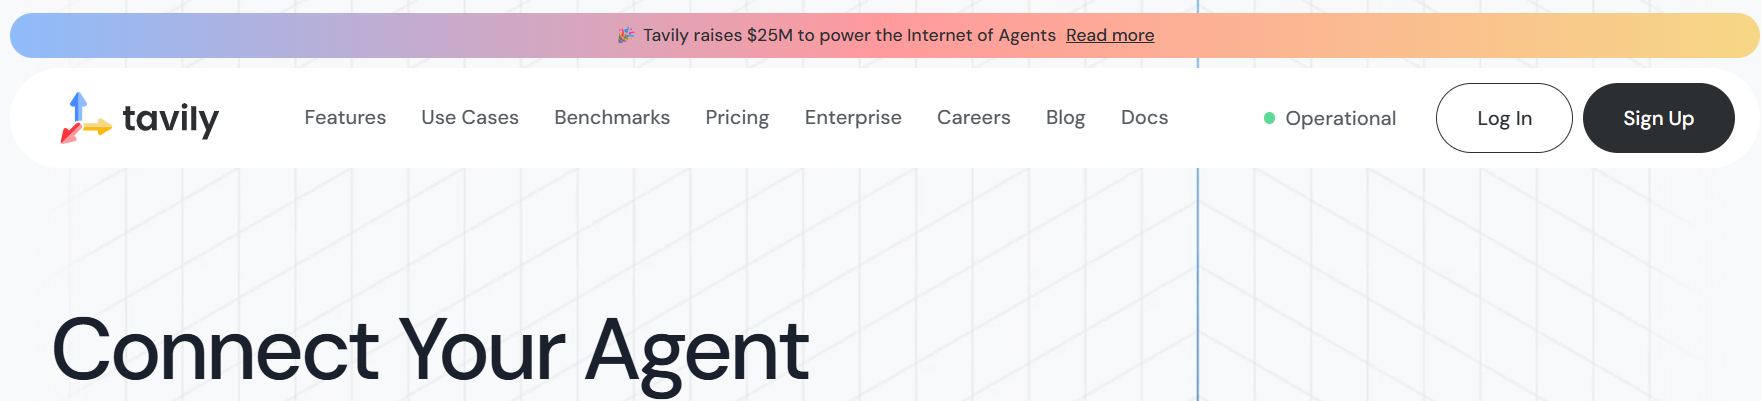

## [Tavily API Key](https://app.tavily.com/home)
> 만약 없다면, 생성 

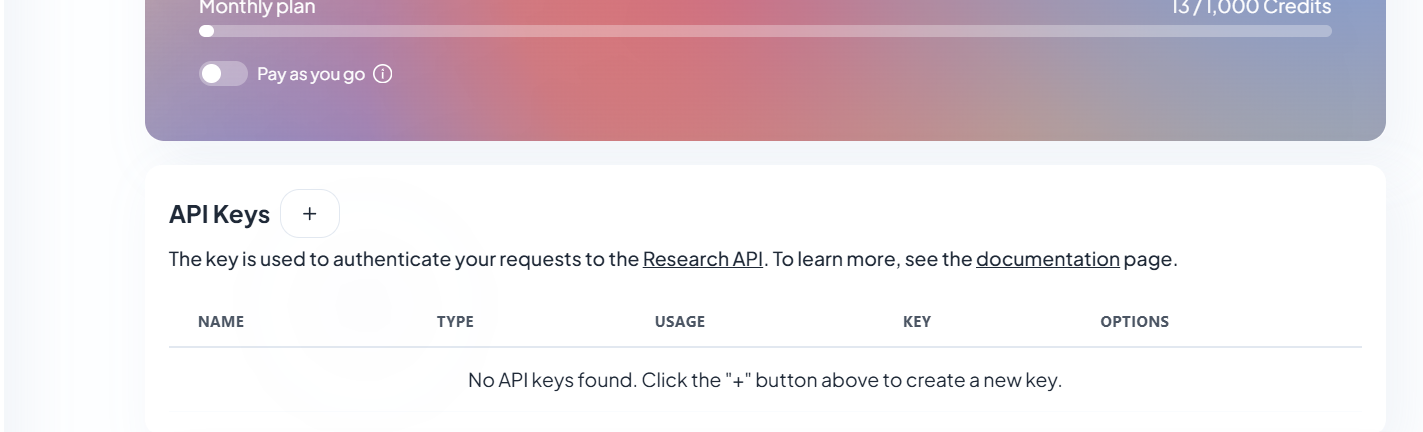

In [1]:
# 필요한 라이브러리 import
import os
from dotenv import load_dotenv

# 환경변수 로드
load_dotenv()

True

# 예제 

## 1단계: TavilySearchResults 도구 생성

In [2]:
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=3,
    topic="general",               # 또는 "news", "finance" 등
    include_answer=True,           # 답변 포함 여부
    include_raw_content=False,     # 원본 내용 포함 여부
    include_images=False,          # 이미지 포함 여부
    search_depth="basic",          # "basic" 또는 "advanced"
    include_domains=[
        "https://www.naver.com", # 뉴스
        "https://www.weatheri.co.kr/", # 날씨 
        "https://kr.investing.com/equities/south-korea" # 주식
    ],
    exclude_domains=None            # 필요하면 제외 도메인 지정 가능
)

## 2단계: 뉴스 요약 도구 만들기

In [3]:
from langchain.tools import tool

@tool
def summarize_news(topic: str) -> str:
    """특정 주제의 최신 뉴스를 검색하고 요약합니다."""
    try:
        # 검색 쿼리 생성
        search_query = f"{topic} 최신 뉴스 한국"
        
        # 검색 실행
        results = search_tool.invoke(search_query)
        
        if not results:
            return f"'{topic}'에 대한 뉴스를 찾을 수 없습니다."
        
        # 결과 요약
        summary = f"'{topic}' 관련 최신 뉴스 요약:\n\n"
        for i, result in enumerate(results[:3], 1):
            title = result.get('title', '제목 없음')
            content = result.get('content', '내용 없음')
            url = result.get('url', '')
            
            summary += f"{i}. {title}\n"
            summary += f"   {content[:100]}...\n"
            summary += f"   {url}\n\n"
        
        return summary
        
    except Exception as e:
        return f"뉴스 검색 중 오류가 발생했습니다: {str(e)}"

## 3단계: 날씨 정보 도구

In [4]:
@tool  
def get_weather_info(city: str) -> str:
    """특정 도시의 현재 날씨 정보를 검색합니다."""
    try:
        search_query = f"{city} 현재 날씨 기온"
        results = search_tool.invoke(search_query)
        
        if not results:
            return f"'{city}'의 날씨 정보를 찾을 수 없습니다."
        
        # 첫 번째 결과에서 날씨 정보 추출
        weather_info = f"{city} 날씨 정보:\n\n"
        for result in results[:2]:
            content = result.get('content', '')
            if content:
                weather_info += f"{content[:150]}...\n\n"
        
        return weather_info
        
    except Exception as e:
        return f"날씨 정보 검색 중 오류가 발생했습니다: {str(e)}"

## 4단계: 주식 정보 도구

In [5]:
@tool
def get_stock_info(stock_name: str) -> str:
    """특정 주식의 현재 가격과 정보를 검색합니다."""
    try:
        search_query = f"{stock_name} 주식 현재가 주가"
        results = search_tool.invoke(search_query)
        
        if not results:
            return f"'{stock_name}' 주식 정보를 찾을 수 없습니다."
        
        stock_info = f"{stock_name} 주식 정보:\n\n"
        for result in results[:2]:
            title = result.get('title', '')
            content = result.get('content', '')
            
            if title:
                stock_info += f"{title}\n"
            if content:
                stock_info += f"{content[:200]}...\n\n"
        
        return stock_info
        
    except Exception as e:
        return f"주식 정보 검색 중 오류가 발생했습니다: {str(e)}"

## 5단계: LLM과 에이전트 설정

### LLM

In [11]:
from langchain_openai import ChatOpenAI

fact_llm = ChatOpenAI(
    model="gpt-5-nano",
    reasoning_effort="high",        # 논리성 강화
)

### tools

In [12]:
# from langchain_openai import ChatOpenAI

# llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
tools = [search_tool, summarize_news, get_weather_info, get_stock_info]

### ChatPromptTemplate

In [13]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    # ① 시스템 메시지: 에이전트 역할 및 동작 규칙 정의
    ("system",
     "You are an AI assistant that must operate strictly through the Agent interface. "
     "You are not allowed to answer directly on your own. "
     "You must always think step by step and use available tools via the Agent to produce a final answer. "
     "When solving a task, explicitly describe your reasoning and the actions you take. "
     "If no tool can help, explain why and then provide your best possible answer through the Agent."),

    # ② 이전 대화 히스토리 (optional)
    MessagesPlaceholder(variable_name="chat_history", optional=True),

    # ③ 사용자 입력
    ("human", "{input}"),

    # ④ 에이전트 내부 추론 / 툴 사용 로그
    MessagesPlaceholder(variable_name="agent_scratchpad"),
])

### AgentExecutor

In [14]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
# from langchain import hub

# # LCEL 방식으로 에이전트 생성
# prompt = hub.pull("hwchase17/openai-tools-agent")
agent = create_openai_tools_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

## 6단계: 검색 테스트

### 뉴스 검색

In [15]:
# 뉴스 검색
new_result = agent_executor.invoke({
    "input": "삼성전자 관련 최신 뉴스를 요약해주세요."
})

print(f"삼성 뉴스: {new_result['output']}")



> Entering new AgentExecutor chain...

Invoking: `summarize_news` with `{'topic': '삼성전자'}`


뉴스 검색 중 오류가 발생했습니다: slice(None, 3, None)
Invoking: `summarize_news` with `{'topic': 'Samsung Electronics'}`


뉴스 검색 중 오류가 발생했습니다: slice(None, 3, None)
Invoking: `tavily_search` with `{'query': 'Samsung Electronics latest news 2025', 'search_depth': 'advanced', 'time_range': 'week', 'topic': 'general'}`


{'query': 'Samsung Electronics latest news 2025', 'follow_up_questions': None, 'answer': 'Samsung Electronics reported $8.48 billion in operating profit for Q3 2025. The company continues to perform strongly. This is the latest financial news available.', 'images': [], 'results': [{'url': 'https://link.naver.com/bridge?url=https%3A%2F%2Fwww%2Ekoreatimes%2Eco%2Ekr%2Flifestyle%2Fbooks%2F20251014%2Flife%2Dmore%2Ddramatic%2Dthan%2Dfiction%2Dwriting%2Dcontest%2Dwinner%2Dshares%2Dstory%2Dof%2Dresilience&dst=naversearchapp%3A%2F%2Finappbrowser%3Furl%3Dhttps%253A%252F%252Fwww%252Ekoreatimes%252Eco%25

### 날씨 검색

In [16]:
# 날씨 검색
weather_result = agent_executor.invoke({
    "input": "서울의 현재 날씨를 알려주세요."
})

print(f"서울 날씨: {weather_result['output']}")



> Entering new AgentExecutor chain...

Invoking: `get_weather_info` with `{'city': 'Seoul'}`


날씨 정보 검색 중 오류가 발생했습니다: slice(None, 2, None)
Invoking: `get_weather_info` with `{'city': '서울'}`


날씨 정보 검색 중 오류가 발생했습니다: slice(None, 2, None)
Invoking: `tavily_search` with `{'include_favicon': False, 'include_images': False, 'query': 'Seoul current weather', 'search_depth': 'basic', 'topic': 'general'}`


{'query': 'Seoul current weather', 'follow_up_questions': None, 'answer': 'As of today, Seoul has a normal weather forecast with no live updates available. The 2025 Seoul Hangang River Light Drone Show may be canceled due to rain or strong winds. Naver Weather page lacks current information.', 'images': [], 'results': [{'url': 'https://e.weatheri.co.kr/forecast/precip.php', 'title': 'WeatherI', 'content': 'Current Weather · Search · Korea · World · Normal. Foreccast > RDAPS. MENU ... 2025-10-15 15 : 00, 2025-10-15 12 : 00, 2025-10-15 09 : 00. 정지. Live updates X', 'score': 0.7458619, 'raw_c